In [1]:
import numpy as np
from scipy.optimize import linear_sum_assignment
from matplotlib import pyplot as plt
from typing import List, Tuple

In [2]:
class Environment():
    def __init__(self, n_arms, probabilities):
        self.n_arms = n_arms
        self.probabilities = probabilities

    def round(self, pulled_arm):
        reward = np.random.binomial(1, self.probabilities[pulled_arm])
        return reward

In [3]:
class Matching_Environment(Environment):
    def __init__(self, n_arms, probabilities, horizon):
        super().__init__(n_arms, probabilities)
        self.t = 0

    def round(self, pulled_arm):
        p = self.probabilities[pulled_arm]
        self.t += 1
        reward = np.random.binomial(1, p)
        return reward

In [4]:
class Learner:
    def __init__(self, n_arms):
        self.n_arms = n_arms
        self.t = 0
        self.rewards_per_arm = [[] for i in range(n_arms)]
        self.collected_rewards = np.array([])

    def pull_arm(self):
        pass

    def update_observations(self, pulled_arm, reward):
        self.rewards_per_arm[pulled_arm].append(reward)
        self.collected_rewards = np.append(self.collected_rewards, reward)

In [5]:
class UCB(Learner):
    def __init__(self, n_arms):
        super().__init__(n_arms)
        self.empirical_means = np.zeros(n_arms)
        self.confidence = np.array([np.inf]*n_arms)

    def pull_arm(self):
        upper_conf = self.empirical_means + self.confidence
        return np.random.choice(np.where(upper_conf == upper_conf.max())[0])

    def update(self, pulled_arm, reward):
        self.t += 1
        self.empirical_means[pulled_arm] = (self.empirical_means[pulled_arm]*(self.t-1) + reward)/self.t
        for a in range(self.n_arms):
            n_samples = len(self.rewards_per_arm[a])
            self.confidence[a] = (2*np.log(self.t)/n_samples)**0.5 if n_samples > 0 else np.inf
        self.update_observations(pulled_arm, reward)

In [6]:
class UCB_Matching(UCB):
    def __init__(self, n_arms, n_rows, n_cols):
        super().__init__(n_arms)
        self.n_rows = n_rows
        self.n_cols = n_cols
        assert n_arms == n_rows * n_cols
        self.empirical_means = np.zeros(n_arms)
        self.confidence = np.array([np.inf]*n_arms)

    def pull_arm(self):
        upper_conf = self.empirical_means + self.confidence
        upper_conf[np.isinf(upper_conf)] = 1000
        # TS -> samples = # draw from beta (on e per arm)
        row_ind, col_ind = linear_sum_assignment(-upper_conf.reshape(self.n_rows, self.n_cols))
        return (row_ind, col_ind)

    def update(self, pulled_arms, rewards):
        # TS -> update beta and alphas of the beta distributions
        self.t += 1
        pulled_arms_flat = np.ravel_multi_index(pulled_arms, (self.n_rows, self.n_cols))
        for pulled_arm, reward in zip(pulled_arms_flat, rewards):
            self.update_observations(pulled_arm, reward)
            self.empirical_means[pulled_arm] = (self.empirical_means[pulled_arm]*(self.t-1) + reward)/self.t
        for a in range(self.n_arms):
            n_samples = len(self.rewards_per_arm[a])
            self.confidence[a] = (2*np.log(self.t)/n_samples)**0.5 if n_samples > 0 else np.inf

In [7]:
p0 = np.array([[1/4, 1, 1/4], [1/2, 1/4, 1/4], [1/4, 1/4, 1]])
T = 3000
n_exp = 10
regret_ucb = np.zeros((n_exp, T))
for j in range(n_exp):
    env = Matching_Environment(p0.size, p0, T)
    learner_UCB = UCB_Matching(p0.size, *p0.shape)
    opt_rew = []
    rew_CD = []
    rew_UCB = []
    for t in range(T):
        p = p0    
        opt = linear_sum_assignment(-p)
        opt_rew.append(p[opt].sum())
        pulled_arm = learner_UCB.pull_arm()
        reward = env.round(pulled_arm) # There is a bug here according to the assistant
        learner_UCB.update(pulled_arm, reward)
        rew_UCB.append(reward.sum())

    regret_ucb[j, :] = np.cumsum(opt_rew)-np.cumsum(rew_UCB)

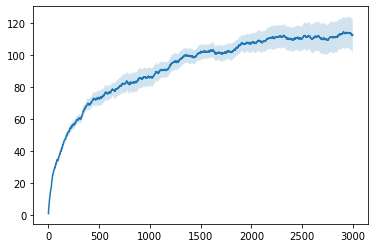

In [8]:
mean = np.mean(regret_ucb, axis=0)
std = np.std(regret_ucb, axis=0)/np.sqrt(n_exp)
plt.figure(0)
plt.plot(mean)
plt.fill_between(range(len(mean)), mean-std, mean+std, alpha = 0.2)
plt.show()